In [1]:
import numpy as np
import pandas as pd
import ray

from plotnine import ggplot, aes, geom_density, geom_line, geom_point

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.envs.asm_fns import get_r_devs, observe_total

In [28]:
def nat_units(obs, env):
    biomass = env.bound * (obs[0] + 1) / 2
    mwt = MINWT + (MAXWT - MINWT) * (obs[1]+1)/2
    return biomass, mwt

#

def full_ep(policy, env):
    episode = {
        't': [],
        'biomass': [],
        'mwt': [],
        'rew': [],
    }
    
    obs, info = env.reset()
    for t in range(env.Tmax):
        action = policy.predict(obs)[0]
        new_obs, rew, term, trunc, info = env.step(action)
        #
        biomass, mwt = nat_units(obs, env)
        episode['t'].append(t)
        episode['biomass'].append(biomass)
        episode['mwt'].append(mwt)
        episode['rew'].append(rew)
        #
        obs=new_obs

    return episode


#

@ray.remote
def generate_rew(policy, env_cls, config):
    ep_rew = 0
    env = env_cls(config=config)
    obs, info = env.reset()
    for t in range(env.Tmax):
        act, info = policy.predict(obs)
        obs, rew, term, trunc, info = env.step(act)
        ep_rew += rew
    return ep_rew


def rew_batch(policy, env_cls, config, batch_size):
    tmax = env_cls().Tmax
    parallel = [generate_rew.remote(policy, env_cls, config) for _ in range(batch_size)]
    rews = ray.get(parallel)
    if ray.is_initialized():
        ray.shutdown()
    return rews

def eval_pol(policy, env_cls, config, n_batches=1, batch_size=300, pb=False):
    batch_iter = range(n_batches)
    if pb:
        from tqdm import tqdm
        batch_iter = tqdm(batch_iter)
    #
    rews = []
    for i in batch_iter:
        rews.append(
            rew_batch(policy=policy, env_cls=env_cls, config=config, batch_size=batch_size)
        )
    return np.array(rews).flatten()

# Reproduction of figures
---

Here we will reproduce the figures from the paper.

## Case 3: trophy fishing (RL advantage)

In [3]:
CONFIG3 = {
    "upow": 1,
    "harvest_fn_name": "trophy"
}
eval_env3 = AsmEnv(config=CONFIG3)

MAXWT = eval_env3.parameters["max_wt"]
MINWT = eval_env3.parameters["min_wt"]
BOUND = eval_env3.bound

In [4]:
from stable_baselines3 import PPO

ppoAgent1 = PPO.load('../saved_agents/results/PPO-AsmEnv-results-trophy-nage-10.zip', device='cpu')
ppoAgent2 = PPO.load('../saved_agents/results/PPO-AsmEnv-results-trophy-nage-10-run2.zip', device='cpu')

In [12]:
import pickle
# still trying to figure out how to load pickle files

# with open('../saved_agents/results/cr_case_3.pkl', 'rb') as pickle_file:
#     cr_3 = pickle.load(pickle_file)

# cr_3 = pickle.load('../saved_agents/results/cr_case_3.pkl')

In [21]:
def to_cr(log_polar_params):
    theta = log_polar_params[1]
    radius = 10 ** log_polar_params[0]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    y2 = log_polar_params[2]
    return {'x1': x1, 'x2': x2, 'y2': y2}

def to_esc(log_params):
    return {'escapement': 10 ** log_params[0]}

def to_msy(params):
    return {'mortality': params[0]}

cr3 = CautionaryRule(env=eval_env3, **to_cr(
    [-0.383730004464649, 0.7853961999069485, 0.08034226735043051]
))
esc3 = ConstEsc(env=eval_env3, **to_esc(
    [0.06615357610240746]
))
msy3 = Msy(env=eval_env3, **to_msy(
    [0.045615795667256265]
))


In [29]:
cr3_rews = eval_pol(
    policy=cr3, env_cls=AsmEnv, config=CONFIG3
)
esc3_rews = eval_pol(
    policy=esc3, env_cls=AsmEnv, config=CONFIG3
)
msy3_rews = eval_pol(
    policy=msy3, env_cls=AsmEnv, config=CONFIG3
)
ppoAgent1_rews = eval_pol(
    policy=ppoAgent1, env_cls=AsmEnv, config=CONFIG3
)
ppoAgent2_rews = eval_pol(
    policy=ppoAgent2, env_cls=AsmEnv, config=CONFIG3
)

2024-05-23 15:59:12,105	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-23 15:59:19,536	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-23 15:59:26,869	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-23 15:59:34,060	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-23 15:59:47,739	INFO worker.py:1749 -- Started a local Ray instance.


In [30]:
cr_rews_df = pd.DataFrame({
    'rew': cr3_rews,
    'agent': 'CR',
})

esc_rews_df = pd.DataFrame({
    'rew': esc3_rews,
    'agent': 'Esc',
})

msy_rews_df = pd.DataFrame({
    'rew': msy3_rews,
    'agent': 'MSY',
})

ppo1_rews_df = pd.DataFrame({
    'rew': ppoAgent1_rews,
    'agent': 'ppo_nr1',
})

ppo2_rews_df = pd.DataFrame({
    'rew': ppoAgent2_rews,
    'agent': 'ppo_nr2',
})

rews_df_case3 = pd.concat(
    [cr_rews_df, esc_rews_df, msy_rews_df, ppo1_rews_df, ppo2_rews_df]
)

In [31]:
# means
(
    np.mean(cr_rews_df.rew),
    np.mean(esc_rews_df.rew),
    np.mean(msy_rews_df.rew),
    np.mean(ppo1_rews_df.rew),
    np.mean(ppo2_rews_df.rew),
)

(31.619016124666274,
 13.479394979731,
 25.510153709904834,
 32.45709450494806,
 51.48817420739415)

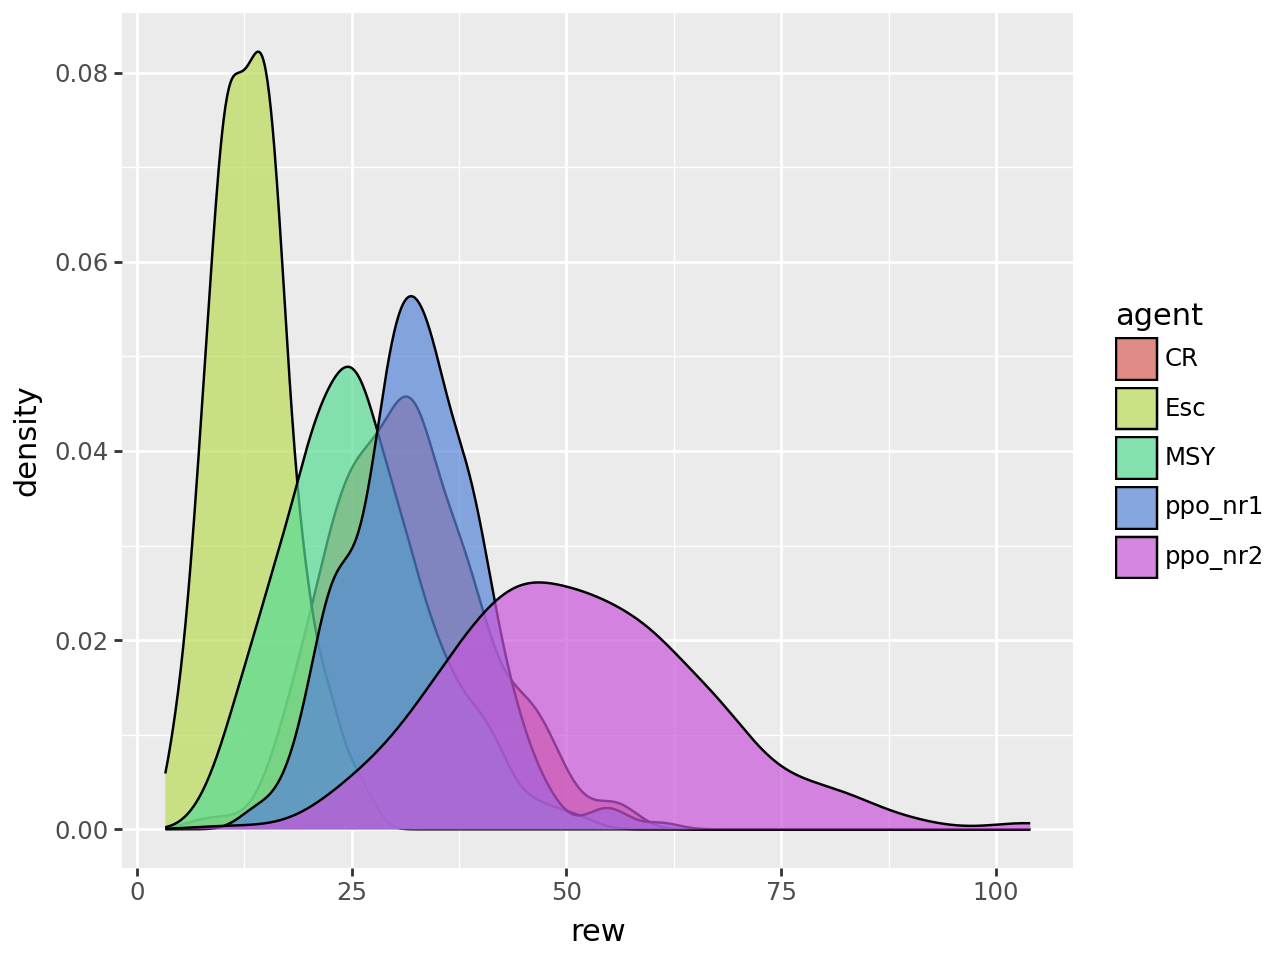

In [32]:
# plot
(
    ggplot(rews_df_case3, aes(x='rew', fill='agent'))+geom_density(alpha=0.7)
)

In [29]:
reprod_env_3 = AsmEnv(
    config={
        'reproducibility_mode': True,
         **CONFIG3
    }
)

Check:  True


In [30]:
cr_ep = pd.DataFrame(
    full_ep(policy=cr3, env=reprod_env_3)
)

ppo1_ep = pd.DataFrame(
    full_ep(policy=ppoAgent1, env=reprod_env_3)
)

ppo2_ep = pd.DataFrame(
    full_ep(policy=ppoAgent2, env=reprod_env_3)
)

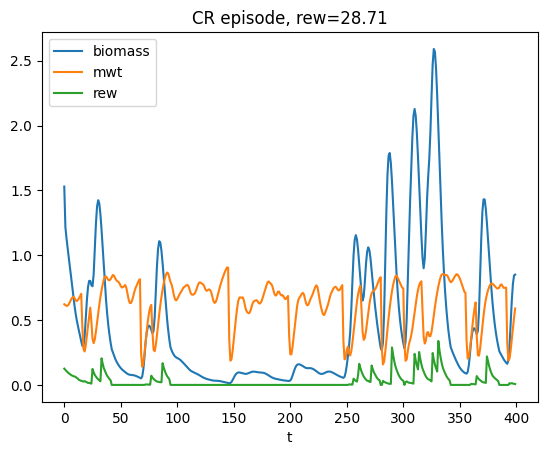

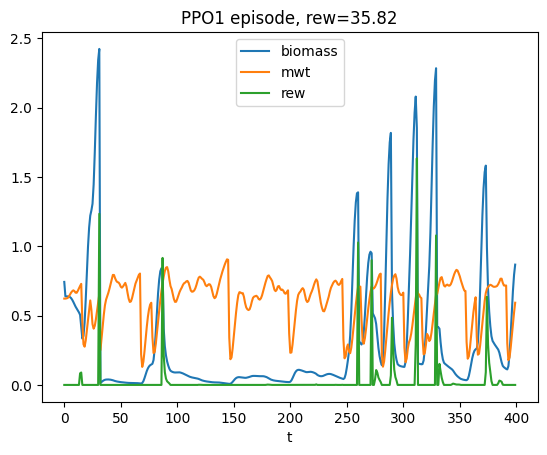

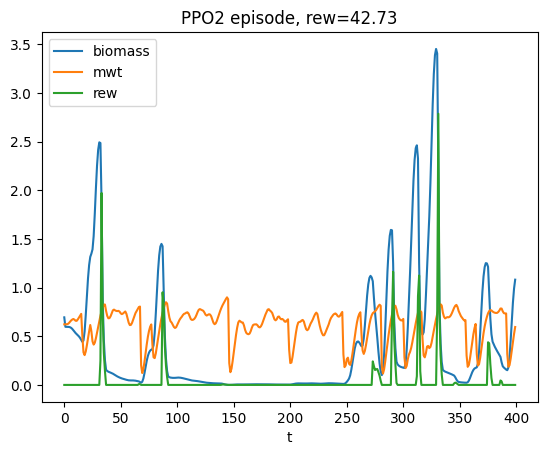

In [51]:
import matplotlib.pyplot as plt
(
    cr_ep[cr_ep.t < 400].plot(x='t', title=f'CR episode, rew={sum(cr_ep.rew):.2f}'),
    ppo1_ep[ppo1_ep.t < 400].plot(x='t', title=f'PPO1 episode, rew={sum(ppo1_ep.rew):.2f}'),
    ppo2_ep[ppo2_ep.t < 400].plot(x='t', title=f'PPO2 episode, rew={sum(ppo2_ep.rew):.2f}'),
)
plt.show()

## Policy functions

In [37]:
def get_policy_df(policy_obj, mwt, minx=-1, maxx=1, nx=500):
    env=AsmEnv(config=CONFIG3)
    obs_list = np.linspace(minx, maxx, nx)
    return pd.DataFrame(
        {
            'obs': obs_list,
            'mwt': [mwt for _ in obs_list],
            'biomass': env.bound * (obs_list + 1)/2,
            'fishing_mortality': [
                (1 + policy_obj.predict(np.float32([obs, mwt]))[0][0]) / 2 
                for obs in obs_list
            ]
        }
    )

In [46]:
cr_df = get_policy_df(cr3, mwt=0.5, maxx=-1+0.14)

ppo1_df_mwt1 = get_policy_df(ppoAgent1, mwt=0.3, maxx=-1+0.14)
ppo1_df_mwt2 = get_policy_df(ppoAgent1, mwt=0.4, maxx=-1+0.14)
ppo1_df_mwt3 = get_policy_df(ppoAgent1, mwt=0.5, maxx=-1+0.14)
ppo1_df_mwt4 = get_policy_df(ppoAgent1, mwt=0.6, maxx=-1+0.14)
ppo1_df_mwt5 = get_policy_df(ppoAgent1, mwt=0.8, maxx=-1+0.14)

ppo2_df_mwt1 = get_policy_df(ppoAgent2, mwt=0.3, maxx=-1+0.14)
ppo2_df_mwt2 = get_policy_df(ppoAgent2, mwt=0.4, maxx=-1+0.14)
ppo2_df_mwt3 = get_policy_df(ppoAgent2, mwt=0.5, maxx=-1+0.14)
ppo2_df_mwt4 = get_policy_df(ppoAgent2, mwt=0.6, maxx=-1+0.14)
ppo2_df_mwt5 = get_policy_df(ppoAgent1, mwt=0.8, maxx=-1+0.14)

Check:  False
Check:  False
Check:  False
Check:  False
Check:  False
Check:  False
Check:  False
Check:  False
Check:  False
Check:  False
Check:  False


In [47]:
ppo1_df = pd.concat(
    [ppo1_df_mwt1,
     ppo1_df_mwt2,
     ppo1_df_mwt3,
     ppo1_df_mwt4,
     ppo1_df_mwt5,
    ]
)

ppo2_df = pd.concat(
    [ppo2_df_mwt1,
     ppo2_df_mwt2,
     ppo2_df_mwt3,
     ppo2_df_mwt4,
     ppo2_df_mwt5,
    ]
)

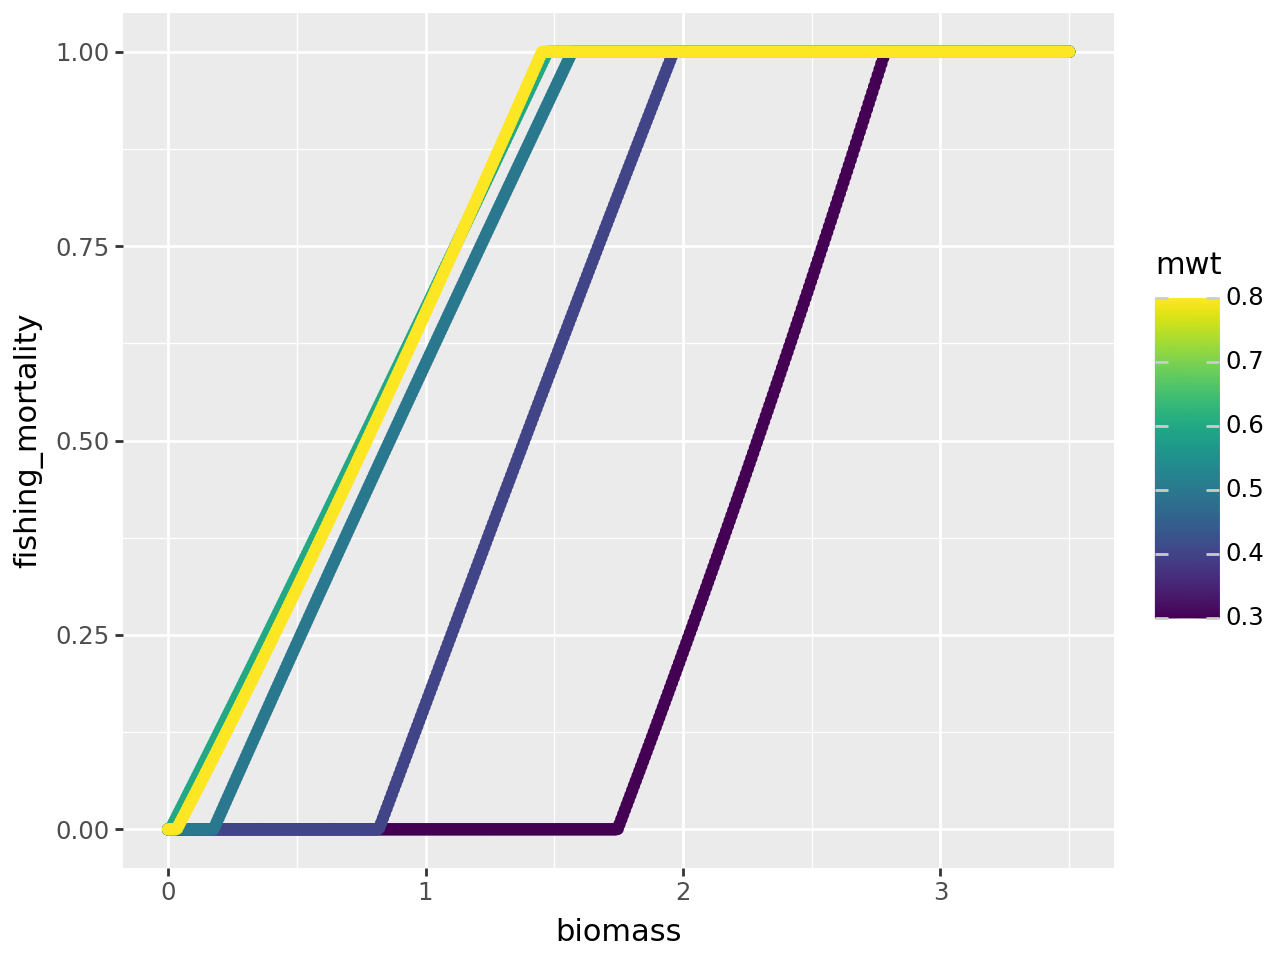

In [48]:
ggplot(
    ppo1_df,
    aes(x='biomass', y='fishing_mortality', color='mwt')
)+geom_point()

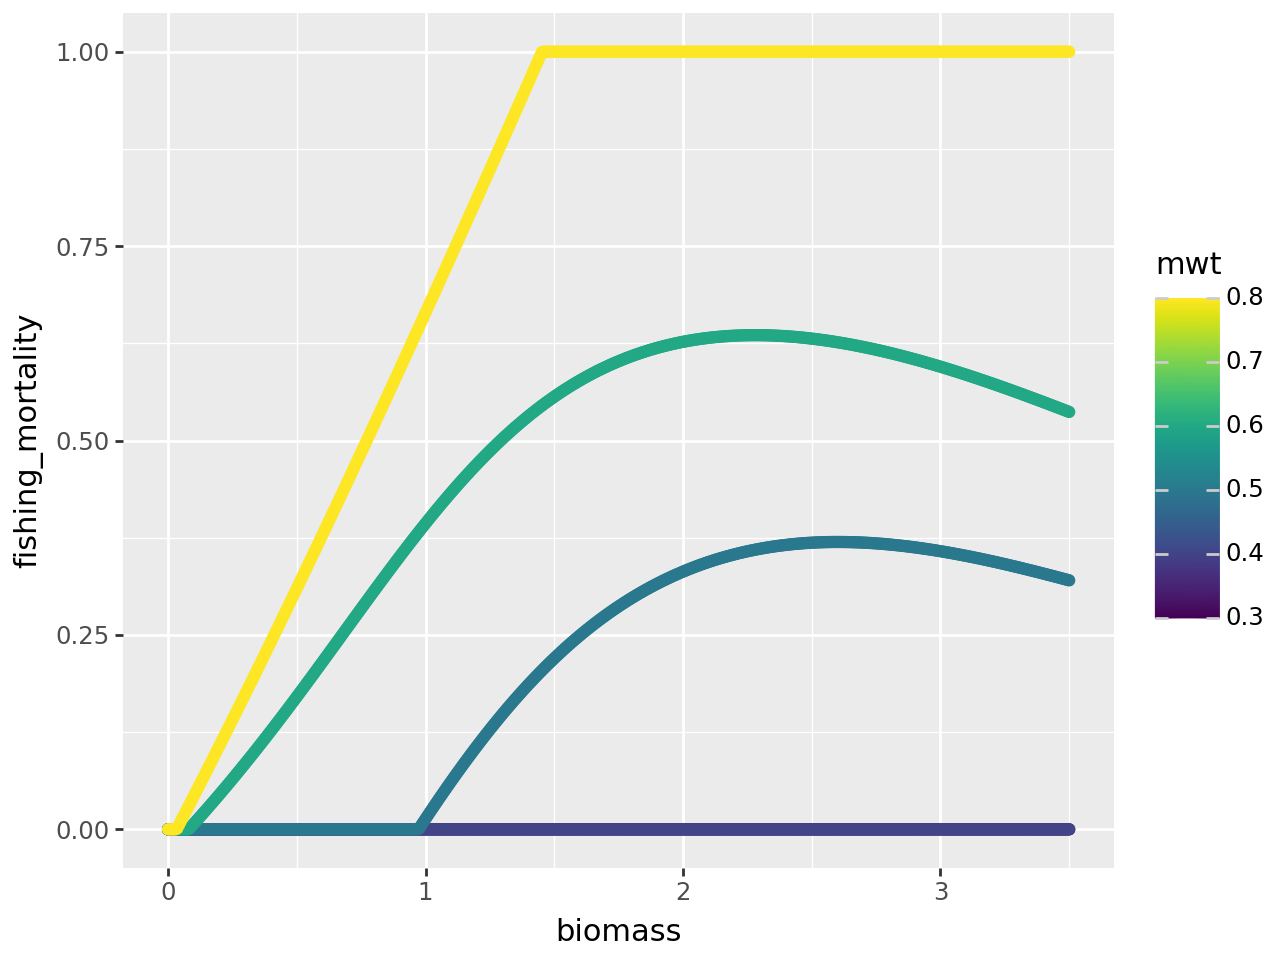

In [49]:
ggplot(
    ppo2_df,
    aes(x='biomass', y='fishing_mortality', color='mwt')
)+geom_point()

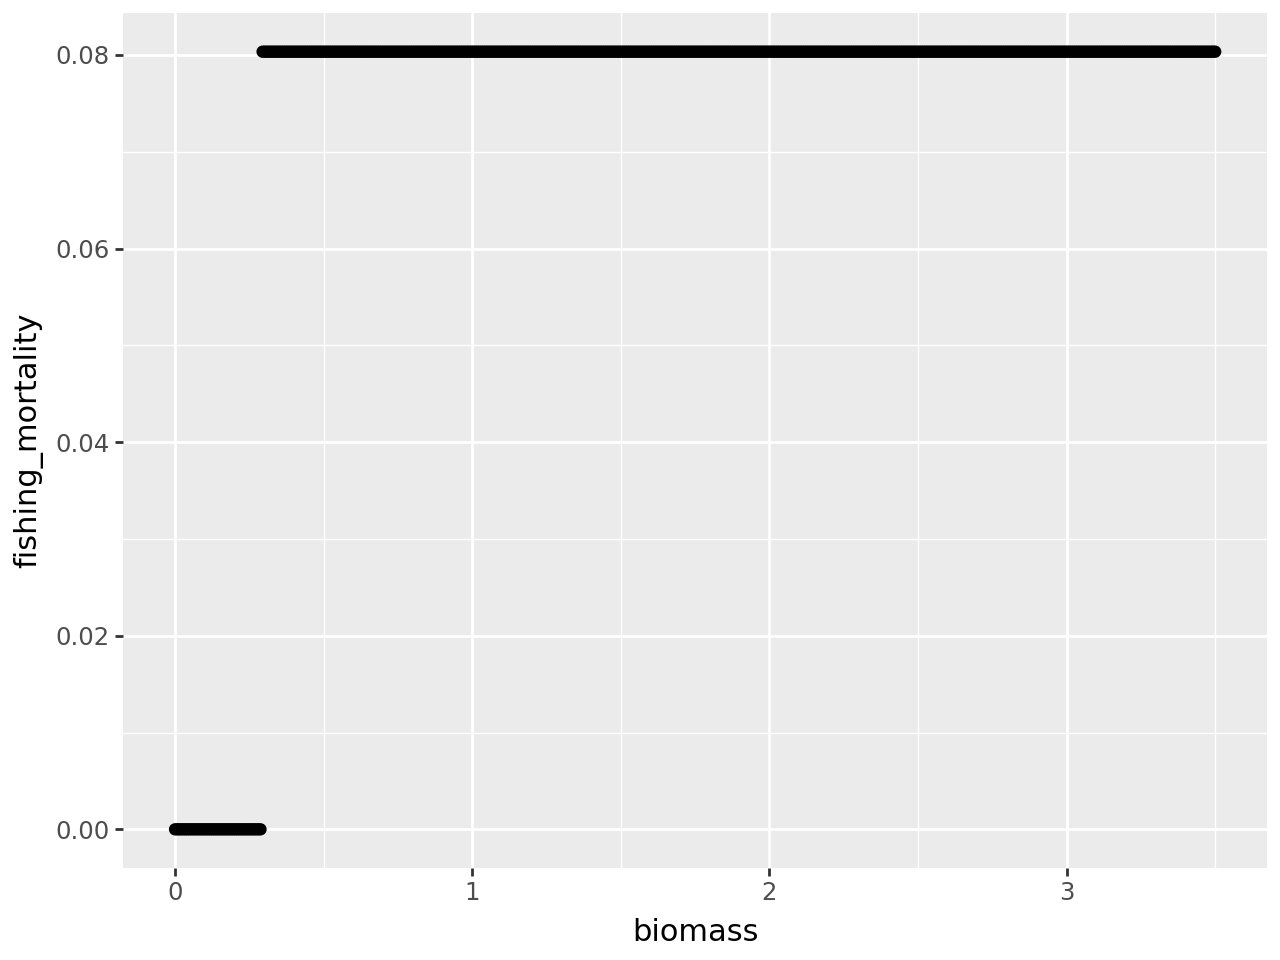

In [52]:
ggplot(
    cr_df,
    aes(x='biomass', y='fishing_mortality')
)+geom_point()

In [6]:
def policy_2obs(policy_obj, minx=-1, miny=-1, maxx=1, maxy=1, nx=100, ny=100, obs1_name = 'obs1', obs2_name='obs2'):
    x_obs = np.linspace(minx, maxx, nx)
    y_obs = np.linspace(miny, maxy, ny)
    obs_generator = itertools.product(x_obs, y_obs)
    # obs_list = list(obs_generator)
    out_dict = {obs1_name: [], obs2_name: [], 'pol': []}
    for (obs1, obs2) in obs_generator:
        out_dict[obs1_name].append( BOUND * (obs1+1)/2 )
        out_dict[obs2_name].append( MINWT + (MAXWT - MINWT) * (obs2+1)/2 )
        action = policy_obj.predict(np.float32([obs1, obs2]))[0][0]
        mortality = (action+1)/2
        out_dict['pol'].append(mortality)
    
    return out_dict

In [7]:
# !pip install seaborn

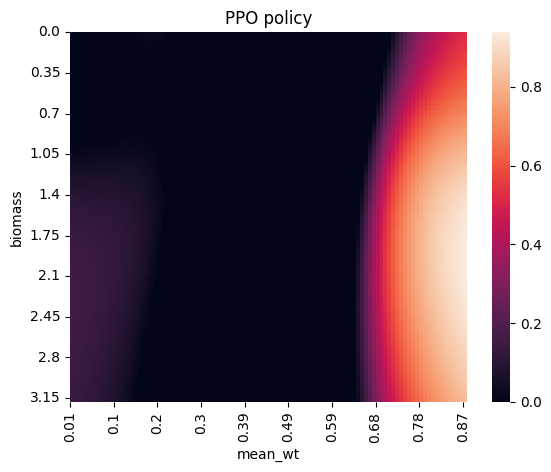

In [11]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

maxx=-1+0.14
maxy=1
n_ticks = 10

ppo_pol = pd.DataFrame(policy_2obs(ppoAgent2, maxx=maxx, maxy=maxy, obs1_name='biomass', obs2_name='mean_wt'))
ppo_pol_pivot = ppo_pol.pivot(index='biomass', columns='mean_wt', values='pol')

ax = sns.heatmap(ppo_pol_pivot)
ax.set_yticks(list(range(0, 101, 100//n_ticks + 1))) # locations as indices, not values
ax.set_yticklabels([eval(f"{ (i / n_ticks) * BOUND * (maxx+1)/ 2 :.2f}") for i in range(n_ticks)])
ax.set_xticks(list(range(0, 101, 100//n_ticks + 1))) # locations as indices, not values
ax.set_xticklabels([
    eval(f"{ MINWT + (i / n_ticks) * (MAXWT-MINWT) * (maxy+1)/ 2:.2f}") for i in range(n_ticks)
])
ax.set_title("PPO policy")
plt.show()